## Egocentric v. Allocentric Coding

this script can be used to perform analyses related to ego v. allocentric coding \\ j.carpenter

### preamble

In [1]:
# import libraries
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import statistics as stats
import scipy.stats
import math
import pandas as pd
from array import *
import seaborn as sns
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from astropy.convolution import convolve, Gaussian2DKernel, Gaussian1DKernel

### load dataset

In [2]:
# load dataset for animal 24116
fileLoc = "D:\\Data\\Dataset\\24116.mat" # insert your file location here
matfile = sio.loadmat(fileLoc) # read in .mat file as dictionary

# parse matfile
accel = matfile["accel"][0]
behaviour = matfile["behaviour"][0]
hd = matfile["hd"][0]
pos = matfile["pos"][0]
rawEEG = matfile["rawEEG"][0]
sessInfo = matfile["sessInfo"][0]
speed = matfile["speed"][0]
SpikeTimes = matfile["SpikeTimes"][0]
SpikeTrain = matfile["SpikeTrain"][0]
trialType = matfile["trialType"][0]
UniqueID = matfile["UniqueID"][0]

# Manually define home-well locations for each session (I'll incorporate this into the dataset later)
hwLoc = [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
         37, 37, 37, 36, 37, 36, 36, 36, 36, 37, 37, 37, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37]

C:\Users\17145\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


### preprocess data

In [3]:
# preprocess the position data- remove outliers
def remove_outliers_LED(pos, matfile, sessNum=0):
    # remove outliers and convert to cm
    conversionFactor = 2.6
    minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
    minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])

    pos_ = np.zeros([len(pos[sessNum][:,0]), 5])
    pos_[:,0] = pos[sessNum][:,0]
    pos_[:,1] = (pos[sessNum][:,1]- minX)/conversionFactor
    pos_[:,2] = (pos[sessNum][:,2]- minY)/conversionFactor
    pos_[:,3] = (pos[sessNum][:,3]- minX)/conversionFactor
    pos_[:,4] = (pos[sessNum][:,4]- minY)/conversionFactor

    # remove outliers
    x = pos_[:,1]; y = pos_[:,2]
    x2 = pos_[:,3]; y2 = pos_[:,4]

    d = np.zeros([len(x)])
    x_prime = np.zeros([len(x)]); y_prime = np.zeros([len(x)])
    x2_prime = np.zeros([len(x)]); y2_prime = np.zeros([len(x)])
    corrPos =  np.zeros([len(x), 5]);

    for idx,val in enumerate(x):
        if idx < len(x)-1:
            d[idx] = np.sqrt((x[idx+1] - x[idx])**2 + (y[idx+1] - y[idx])**2)
            if d[idx] < 2:
                x_prime[idx:idx+1] = x[idx:idx+1]; y_prime[idx:idx+1] = y[idx:idx+1];
                x2_prime[idx:idx+1] = x2[idx:idx+1]; y2_prime[idx:idx+1] = y2[idx:idx+1];

            else:
                x_prime[idx:idx+1] = np.nan; y_prime[idx:idx+1] = np.nan;
                x2_prime[idx:idx+1] = np.nan; y2_prime[idx:idx+1] = np.nan;

    corrPos[:,0]=pos_[:,0]; 
    corrPos[:,1]=x_prime + np.absolute(np.nanmin(x_prime)); corrPos[:,2]=y_prime + np.absolute(np.nanmin(y_prime));
    corrPos[:,3]=x2_prime + np.absolute(np.nanmin(x2_prime)); corrPos[:,4]=y2_prime + np.absolute(np.nanmin(y2_prime))

    return corrPos

# run for all sessions
pos_outliers_removed = {} # create dictionary
for ii in range(0,len(pos)):
    corrPos = remove_outliers_LED(pos, matfile, sessNum=ii)
    pos_outliers_removed[ii] = corrPos

### initialize class and define methods

In [18]:
class dataset:
    
    def __init__(self, animalID, accel, behaviour, hd, pos, rawEEG, sessInfo, speed, SpikeTimes, SpikeTrain, trialType, UniqueID, hwLoc):
        self.animalID = animalID
        self.accel = accel
        self.behaviour = behaviour
        self.hd = hd
        self.pos = pos
        self.rawEEG = rawEEG
        self.sessInfo = sessInfo
        self.speed = speed
        self.SpikeTimes = SpikeTimes
        self.SpikeTrain = SpikeTrain
        self.trialType = trialType
        self.UniqueID = UniqueID
        self.hwLoc = hwLoc

    def getAccel(self, sessNum=0):
        # convert this to cm
        return self.accel[sessNum]

    def getBehaviour(self, sessNum=0):
        return self.behaviour[sessNum][0]
    
    def getHD(self, sessNum=0):
        return self.hd[sessNum][:,0]
    
    def getPos(self, sessNum=0):
        return self.pos[sessNum]
    
    def getRawEEG(self, sessNum=0, chan=0):
        return self.rawEEG[sessNum][0][chan]
    
    def getSessInfo(self, sessNum=0, cat='minX'):
        switcher={
                'winMinX':float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0]),
                'winMaxX':float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0]),
                'winMinY':float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0]),
                'winMaxY':float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0]),
                'minX':float(matfile["sessInfo"][0][sessNum][0]["min_x"][0][0][0][0]),
                'maxX':float(matfile["sessInfo"][0][sessNum][0]["max_x"][0][0][0][0]),
                'minY':float(matfile["sessInfo"][0][sessNum][0]["min_y"][0][0][0][0]),
                'maxY':float(matfile["sessInfo"][0][sessNum][0]["max_y"][0][0][0][0]),
                'trial_time':matfile["sessInfo"][0][sessNum][0]["trial_time"][0][0][0][0],
                'trial_date':matfile["sessInfo"][0][sessNum][0]["trial_date"][0][0][0][0],
                'duration':float(matfile["sessInfo"][0][sessNum][0]["duration"][0][0][0][0]),
                'num_pos_samples':float(matfile["sessInfo"][0][sessNum][0]["num_pos_samples"][0][0][0][0]),
                'pixels_per_metre':float(matfile["sessInfo"][0][sessNum][0]["pixels_per_metre"][0][0][0][0]),
                'bytes_per_coord':int(matfile["sessInfo"][0][sessNum][0]["bytes_per_coord"][0][0][0][0]),
                'bytesPerTS':int(matfile["sessInfo"][0][sessNum][0]["bytesPerTS"][0][0][0][0]),
                'sampleRate':matfile["sessInfo"][0][sessNum][0]["sampleRate"][0][0][0][0], 
                'EEGsamplesPerPos':int(matfile["sessInfo"][0][sessNum][0]["EEGsamplesPerPos"][0][0][0][0]),
        }
        return switcher.get(
            cat,"Invalid category input. Valid inputs include: 'winMinX', 'winMaxX', 'winMinY', 'winMaxY',\
            'minX', 'maxX', 'minY', 'maxY', 'trial_time', 'trial_date', 'duration', 'num_pos_samples', \
            'pixels_per_metre', 'bytes_per_coord', 'bytesPerTS', 'sampleRate', 'EEGsamplesPerPos'")

    def getSpeed(self, sessNum=0):
        # get speed in cm/s
        # conversion factor assumes that the box is 1.5x1.5 m
        # each dimension of the box is 390 units long
        # thus, 1 cm = 2.6 units
        return self.speed[sessNum]/2.6
    
    def getSpikeTimes(self, sessNum=0, unitNum=0):
        return self.SpikeTimes[sessNum][0][unitNum]
    
    def getSpikeTrain(self, sessNum=0, unitNum=0):
        return self.SpikeTrain[sessNum][0][unitNum][0]
    
    def getTrialType(self, sessNum=0):
        return self.trialType[sessNum][0]
    
    def getUID(self, sessNum=0, unitNum=0):
        return self.UniqueID[sessNum][0][unitNum][0][0]

    def getHwLoc(self, sessNum=0):
        return self.hwLoc[sessNum]
    
    def getHwCoord(self, sessNum=0):
        homeLocation = self.hwLoc[sessNum]
        switcher={
                37: [90, 82], # [370, 260]
                36: [155, 15] #[550,90]
            }
        return switcher.get(homeLocation,"Invalid HW value.")
    
    def instFR(self, sigma=2, sessNum=0, unitNum=0):
        spikesNow = self.SpikeTrain[sessNum][0][unitNum][0] # grab spikes for session 
        Fs = self.sampleFreq(sessNum) # sampling frequency
        firingRate = spikesNow/Fs # instantaneous FR in Hz (spikes/second)
        fr = scipy.ndimage.gaussian_filter1d(firingRate, sigma) # smooth w/ gaussian (100 or 200 ms)
        return fr
    
    def getBearingAllo(self, sessNum=0, refLoc=[90, 82]):
        pos_ = self.getPos(sessNum=sessNum)
        xAnimal = pos_[:,1]
        yAnimal = pos_[:,2]
        xRef = refLoc[0]
        yRef = refLoc[1]
        bearingAllo = np.rad2deg(np.arctan2(yRef-yAnimal, xRef-xAnimal)+np.pi)
        return bearingAllo
    
    def getBearingEgo(self, sessNum=0, refLoc=[90, 82]):
        bearingAllo = self.getBearingAllo(sessNum=sessNum, refLoc=refLoc)
        hdAllo = self.getHD(sessNum=sessNum)
        bearingEgo = np.subtract(bearingAllo, hdAllo)
        return bearingEgo
    
    def getDistanceToRef(self, sessNum=0):
        xx = self.getPos(sessNum=sessNum)[:,1]
        yy = self.getPos(sessNum=sessNum)[:,2]
        trialType_ = self.getTrialType(sessNum=sessNum)

        if trialType_ == 'FM':
            refLoc_ = self.getHwCoord(sessNum=sessNum)
            refX = refLoc_[0]; refY = refLoc_[1]
        elif trialType_ == 'OF':
            refX = 85; refY = 80 # center of arena
        else:
            refX = 85; refY = 80 # center of arena

        # compute distance
        d = np.sqrt((refX-xx)**2 + (refY-yy)**2)

        # compute maximum distance
        bottom_left, bottom_right, top_left, top_right = self.getBoxCorners(sessNum=sessNum)
        corners = [bottom_left, bottom_right, top_left, top_right]
        dist_to_corners = np.array([])
        for corner_loc in corners:
            dist_to_corners = np.append(arr=dist_to_corners, values=np.sqrt((refX-corner_loc[0])**2 + (refY-corner_loc[1])**2))
        
        max_corner_dist = np.nanmax(dist_to_corners)

        # check that all values are smaller than the maximum distance 
        for val in ~np.isnan(d):
            if val > max(dist_to_corners):
                print(val) # but do some replacement here
                
        return d, max_corner_dist
    
    def findWellLoc(self, sessNum=0, testX=90, testY=82):
        pos_ = self.getPos(sessNum=sessNum)
        hwLoc = self.getHwLoc(sessNum=sessNum)
        trialType = self.getTrialType(sessNum=sessNum)
        figTitle = "Type: " + str(trialType) + " Loc: " + str(hwLoc)
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot()
        ax.hlines(y=testY, xmin=0, xmax=160, colors = 'r', linewidth= 3)
        ax.vlines(x=testX, ymin=0, ymax=160, colors = 'r', linewidth = 3)
        ax.plot(pos_[:,1], pos_[:,2], linewidth = .5)
        ax.set_title(label=figTitle)
        ax.set_aspect('equal')
        return
    
    def findBorderLoc(self, sessNum=0, testX1=0, testX2=147, testY1=0, testY2=150):
        pos_ = self.getPos(sessNum=sessNum)
        hwLoc = self.getHwLoc(sessNum=sessNum)
        trialType = self.getTrialType(sessNum=sessNum)
        figTitle = "Type: " + str(trialType) + " Loc: " + str(hwLoc)
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot()

        ax.hlines(y=testY1, xmin=0, xmax=150, colors = 'r', linewidth= 3)
        ax.hlines(y=testY2, xmin=0, xmax=150, colors = 'r', linewidth= 3)
        ax.vlines(x=testX1, ymin=0, ymax=150, colors = 'r', linewidth = 3)
        ax.vlines(x=testX2, ymin=0, ymax=150, colors = 'r', linewidth = 3)
        ax.set_aspect('equal')

        ax.plot(pos_[:,1], pos_[:,2], linewidth = .5)
        ax.set_title(label=figTitle)
        
    def getBoxCorners(self, sessNum=0):
        # get box corner coordinates
        P = self.getPos(sessNum=sessNum)
        xx = P[:,1]; yy = P[:,2]
        minX = np.nanmin(xx); maxX = np.nanmax(xx);
        minY = np.nanmin(yy); maxY = np.nanmax(yy);
        bottom_left = [minX, minY]; bottom_right = [maxX, minY];
        top_left = [minX, maxY]; top_right = [maxX, maxY]
        return bottom_left, bottom_right, top_left, top_right
    
    def classifyUnits(self, sessNum=0):
        ST = self.SpikeTimes[sessNum][0]
        unitList = np.zeros((len(ST), 2))
        for i,t in enumerate(ST):
            unitList[i,0] = i
            unitList[i,1] = len(t)
        return unitList
    
    def angTuningCurve(self, sessNum=0, unitNum=0, refLoc=[370, 260], save=False, polar=False):
        # get egocentric bearing values (S26,HW27)
        bearingEgo = self.getBearingEgo(sessNum=sessNum, refLoc=refLoc)
        ST = self.getSpikeTrain(sessNum=sessNum, unitNum=unitNum)
        Fs = stats.mode(np.diff(self.getPos(sessNum=sessNum)[:,0])) # sampling freq

        # bin angular data
        numBins = 30 # 12 degree bins
        edges = np.linspace(0, 360, numBins)

        # compute angular occupancy
        occupancy, edgesHist = np.histogram(bearingEgo, bins=30, range=(0,360))
        angInd = np.digitize(bearingEgo, edgesHist);

        # convert hdOccupancy to s
        occupancy = occupancy*Fs

        # compute number of spikes in each time bin
        spikesPerAngle = [];

        # compute number of spikes in each time bin
        for iBin in np.arange(0, numBins):
            spikesPerAngle.append(sum(ST[angInd == iBin]))
        spikesPerAngle = np.asarray(spikesPerAngle)

        # compute probability density (proportion of time spent at each angle)
        probDens = occupancy/np.sum(occupancy)

        # compute average firing rates across all angles
        meanFR = np.sum(spikesPerAngle)/np.sum(occupancy)

        # compute tuning curve (average FR for each angle)
        angularTuning = spikesPerAngle/occupancy
        angularTuning_smooth = scipy.ndimage.gaussian_filter1d(angularTuning, sigma=2) # smooth w/ gaussian
        
        # make figure title
        UID = self.getUID(sessNum=sessNum, unitNum=unitNum)
        figTitle = "UID: " + str(UID) + " Sess: " + str(sessNum)
        
        # choose between polar and cartesian plot
        if polar == True:
            fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection='polar'), figsize = (4,5));
            plt.style.use('seaborn-white')
            axs.plot(edges, angularTuning_smooth, color = 'k', linewidth = 1.25);
            axs.yaxis.get_major_locator().base.set_params(nbins=5); # reduce number of y-ticks
            axs.tick_params(axis='x', labelsize=15, colors = 'gray');
            axs.tick_params(axis='y', labelsize=15, colors = 'gray');
            fontStuff = {'fontsize': 15}
            axs.set_title(label=figTitle, fontdict=fontStuff, pad=20)
            
        elif polar == False:
            fig = plt.figure(figsize=(4,4))
            ax1 = fig.add_subplot(111)
            ax1.set_xlabel("Center Bearing (degrees)", fontsize=16)
            ax1.set_ylabel("Firing Rate (Hz)", fontsize=16)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.tick_params(labelsize=14)
            ax1.tick_params(axis='x', labelrotation=45)
            ax1.set_xlim([0, 360])
            ax1.set_ylim([0, max(angularTuning_smooth)])
            ax1.set_xticks([0, 90, 180, 270, 360])
            ax1.set_title(label=figTitle, fontdict=fontStuff, pad=20)
            cartPlot, = ax1.plot([], [], color = 'k',linewidth = 1.25)
            cartPlot.set_data(edges, angularTuning_smooth)
        
        # decide whether to save the figure
        if save == True:
            filepath = "D:\\egoBearing\\" + str(UID) + "-" + str(sessNum) + ".png" 
            fig.savefig(filepath, bbox_inches='tight', pad_inches=.25)
            
#     def distanceTuningCurve(sessNum=0, unitNum=0, refLoc=[370, 260], save=False):

### define class instances

In [19]:
# create instance for animal 24116
A24116 = dataset('24116', accel, behaviour, hd, pos_outliers_removed, rawEEG, sessInfo, speed, SpikeTimes, SpikeTrain, trialType, UniqueID, hwLoc)

### playground

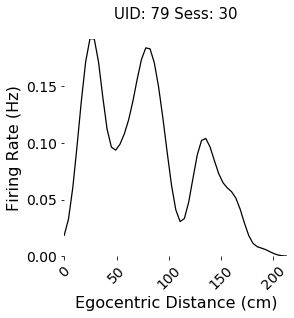

In [59]:
# scratch for egocentric distance tuning curves

sessNum = 30
unitNum=0
# distnace tuning curves
d, max_corner_dist = A24116.getDistanceToRef(sessNum=sessNum)
ST = A24116.getSpikeTrain(sessNum=sessNum, unitNum=unitNum) # spiketrain
Fs = stats.mode(np.diff(A24116.getPos(sessNum=sessNum)[:,0])) # sampling freq

# bin distance data (4 cm bins)
numBins = int(max_corner_dist/4)
edges = np.linspace(0, max_corner_dist, numBins)

# compute occupancy
occupancy, edgesHist = np.histogram(d, bins=numBins, range=(0,max_corner_dist))
distInd = np.digitize(d, edgesHist);

# convert Occupancy to s
occupancy = occupancy*Fs

# compute number of spikes in each time bin
spikesPerDist = [];
for iBin in np.arange(0, numBins):
    count = sum(ST[distInd == iBin])
    spikesPerDist.append(count)
spikesPerDist = np.asarray(spikesPerDist)

# compute probability density (proportion of time spent at each angle)
probDens = occupancy/np.sum(occupancy)

# compute average firing rates across all angles
meanFR = np.sum(spikesPerDist)/np.sum(occupancy)

# compute tuning curve (average FR for each angle)
distTuning = spikesPerDist/occupancy
distTuning_smooth = scipy.ndimage.gaussian_filter1d(distTuning, sigma=2) # smooth w/ gaussian

# make figure title
UID = A24116.getUID(sessNum=sessNum, unitNum=unitNum)
figTitle = "UID: " + str(UID) + " Sess: " + str(sessNum)

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Egocentric Distance (cm)", fontsize=16)
ax1.set_ylabel("Firing Rate (Hz)", fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(labelsize=14)
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_xlim([0, max_corner_dist])
ax1.set_ylim([0, max(distTuning_smooth)])
fontStuff = {'fontsize': 15}
ax1.set_title(label=figTitle, fontdict=fontStuff, pad=20)
# ax1.set_xticks([0, 90, 180, 270, 360])
cartPlot, = ax1.plot([], [], color = 'k',linewidth = 1.25)
cartPlot.set_data(edges, distTuning_smooth)

# # decide whether to save the figure
# if save == True:
# filepath = "D:\\egoBearing\\" + str(UID) + "-" + str(sessNum) + ".png" 
# fig.savefig(filepath, bbox_inches='tight', pad_inches=.25)



In [32]:
# interactive mode?
mpl.is_interactive()
plt.ioff()

In [69]:
# generate tuning curves (ego bearing)
# END = len(pos)
# for sessNum in range(0,END):
#     if A24116.getTrialType(sessNum=sessNum) == 'FM':
#         home_coord = A24116.getHwCoord(sessNum=sessNum)
#     elif A24116.getTrialType(sessNum=sessNum) == 'OF':
#         home_coord = [370, 260] # center of arena
#         for unitNum in range(0, len(A24116.SpikeTimes[sessNum][0])):
#             A24116.angTuningCurve(sessNum=sessNum, unitNum=unitNum, refLoc=home_coord, save=True, polar=False)